In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-dataset/item_properties_part1.csv
/kaggle/input/ecommerce-dataset/category_tree.csv
/kaggle/input/ecommerce-dataset/item_properties_part2.csv
/kaggle/input/ecommerce-dataset/events.csv


### Try to create an algorithm that recommends products to visitors/customers by using data from "view" events for any visitor in the published log with two different models:

##### 1. Matrix factorization.


In [6]:
category_df = pd.read_csv("../input/ecommerce-dataset/category_tree.csv")
event_df = pd.read_csv("../input/ecommerce-dataset/events.csv")
item1_df = pd.read_csv("../input/ecommerce-dataset/item_properties_part1.csv")
item2_df = pd.read_csv("../input/ecommerce-dataset/item_properties_part2.csv")

In [7]:
category_df.sample(10)

,categoryid,parentid
1391,573,252.0
1198,261,1229.0
1380,872,1600.0
325,1674,1420.0
1569,103,630.0
649,485,1335.0
1297,1544,679.0
851,641,768.0
1007,671,1426.0
847,1142,485.0


In [8]:
category_df.info()
len(category_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


1669

In [9]:
event_df.sample(10)

,timestamp,visitorid,event,itemid,transactionid
51166,1433351412700,1192879,view,73200,NaN
1508975,1430828507680,1353692,view,289395,NaN
489384,1435169710367,500037,view,448494,NaN
2207841,1436375455288,625701,view,96680,NaN
2094604,1435893235551,244487,view,428923,NaN
575554,1435603597724,85546,view,239020,NaN
839371,1439521610415,1146451,view,104756,NaN
254416,1434134522163,886702,view,297721,NaN
1388999,1442193149484,849092,view,360994,NaN
631066,1438568779415,464024,view,433037,NaN


In [10]:
event_df['event_datetime'] = pd.to_datetime(event_df['timestamp'], unit = 'ms')
event_df

,timestamp,visitorid,event,itemid,transactionid,event_datetime
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106
...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703


In [11]:
event_df.info()
len(event_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       int64         
 1   visitorid       int64         
 2   event           object        
 3   itemid          int64         
 4   transactionid   float64       
 5   event_datetime  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 126.2+ MB


2756101

In [12]:
event_df["transactionid"].value_counts()

7063.0     31
765.0      28
8351.0     27
2753.0     23
6993.0     21
           ..
17515.0     1
1200.0      1
8006.0      1
15418.0     1
17579.0     1
Name: transactionid, Length: 17672, dtype: int64

# We will concat all item property 

In [13]:
item_df = pd.concat([item1_df, item2_df], axis=0)
item_df.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


In [14]:
item_df['event_datetime'] = pd.to_datetime(item_df['timestamp'], unit = 'ms')
item_df

,timestamp,itemid,property,value,event_datetime
0,1435460400000,460429,categoryid,1338,2015-06-28 03:00:00
1,1441508400000,206783,888,1116713 960601 n277.200,2015-09-06 03:00:00
2,1439089200000,395014,400,n552.000 639502 n720.000 424566,2015-08-09 03:00:00
3,1431226800000,59481,790,n15360.000,2015-05-10 03:00:00
4,1431831600000,156781,917,828513,2015-05-17 03:00:00
...,...,...,...,...,...
9275898,1433646000000,236931,929,n12.000,2015-06-07 03:00:00
9275899,1440903600000,455746,6,150169 639134,2015-08-30 03:00:00
9275900,1439694000000,347565,686,610834,2015-08-16 03:00:00
9275901,1433646000000,287231,867,769062,2015-06-07 03:00:00


In [15]:
item_df.info()
len(item_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20275902 entries, 0 to 9275902
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       int64         
 1   itemid          int64         
 2   property        object        
 3   value           object        
 4   event_datetime  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 928.2+ MB


20275902

# Data Exploration  

In [16]:
event_df['event_datetime'].describe()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                        2756101
unique                       2750455
top       2015-07-15 17:03:16.576000
freq                               6
first     2015-05-03 03:00:04.384000
last      2015-09-18 02:59:47.788000
Name: event_datetime, dtype: object

In [17]:
event_df['event'].value_counts()

view           2664312
addtocart        69332
transaction      22457
Name: event, dtype: int64

In [18]:
type(event_df)

pandas.core.frame.DataFrame

<AxesSubplot:xlabel='event', ylabel='count'>

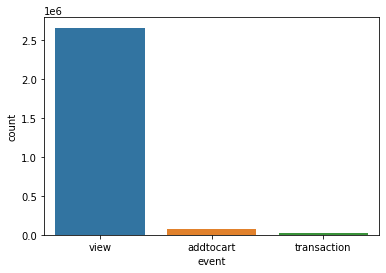

In [19]:
sns.countplot(x = 'event', data = event_df)

In [20]:
event_df.drop_duplicates(keep ='first',inplace = True)

In [21]:
# we want to see the number of the website visitors
print('Total Visitors:', len(event_df['visitorid']))
print('Unique Visitors:', len(event_df['visitorid'].unique()))

Total Visitors: 2755641
Unique Visitors: 1407580


### This might mean that every user made two actions on the website

In [22]:
event_df.visitorid.value_counts()

1150086    7757
530559     4328
152963     3024
895999     2474
163561     2410
           ... 
578031        1
643534        1
698825        1
843029        1
1184451       1
Name: visitorid, Length: 1407580, dtype: int64

that is mean some users visited the website only one time and others made number of actions

we want to check how many users made at least one transaction

In [23]:
print('number of unique purchases: ', len(event_df[event_df.transactionid.notnull()].visitorid.unique()))
print('Total purchases amount: ', len(event_df[event_df.transactionid.notnull()]))

number of unique purchases:  11719
Total purchases amount:  22457


we have from all unique customers we had only 11719 that made a real transaction 

and all transactions are 22457

#### And also we want to see most viewed items

In [24]:
most_viewed_items = event_df[event_df['event'] == 'view'].itemid.value_counts()
most_viewed_items

187946    3410
461686    2538
5411      2325
370653    1854
219512    1740
          ... 
256592       1
462817       1
436980       1
107400       1
177353       1
Name: itemid, Length: 234838, dtype: int64

<AxesSubplot:>

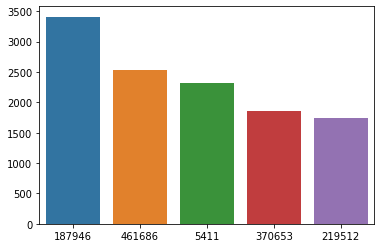

In [25]:
# most viewed 5 elements
x = most_viewed_items[:5].index #id of item 
y = most_viewed_items[:5].values#no. of views
sns.barplot(x = x,
            y = y,
            order = x)

#### Most added to cart item

In [26]:
most_added_to_cart_items = event_df[event_df['event'] == 'addtocart'].itemid.value_counts()
most_added_to_cart_items

461686    304
312728    161
409804    152
320130    141
29196     135
         ... 
463892      1
243008      1
983         1
339543      1
47199       1
Name: itemid, Length: 23903, dtype: int64

<AxesSubplot:>

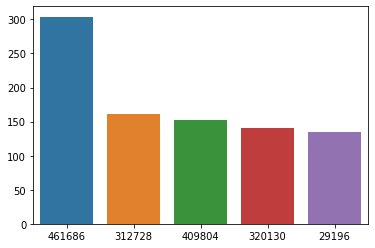

In [27]:
x = most_added_to_cart_items[:5].index #id of item 
y = most_added_to_cart_items[:5].values#no. of views
sns.barplot(x = x,
            y = y,
            order = x)

#### We will do the same for the most purchased item

In [28]:
most_purchased_items = event_df[event_df['event'] == 'transaction'].itemid.value_counts()
most_purchased_items

461686    133
119736     97
213834     92
312728     46
7943       46
         ... 
411039      1
233427      1
78388       1
311292      1
446271      1
Name: itemid, Length: 12025, dtype: int64

<AxesSubplot:>

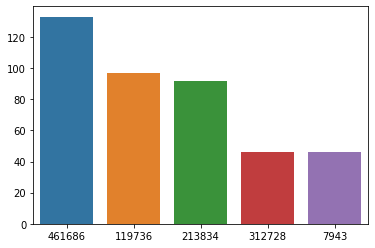

In [29]:
# most viewed 5 elements
x = most_purchased_items[:5].index 
y = most_purchased_items[:5].values
sns.barplot(x = x,
            y = y,
            order = x)

# Feature Engineering for some EDA


In [30]:
# from datetime import date
import datetime
import calendar

#### Extract date from timestamp

In [31]:
event_df = event_df.assign(date=pd.Series(datetime.datetime.fromtimestamp(i/1000).date() for i in event_df.timestamp))
event_df.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02


In [32]:
def get_day(x):
    day = calendar.day_name[x.weekday()]
    return day

In [33]:
event_df['day_of_week'] = event_df['event_datetime'].map(get_day)
event_df['Year'] = event_df['event_datetime'].map(lambda x: x.year)
event_df['Month'] = event_df['event_datetime'].map(lambda x: x.month)
event_df['Day'] = event_df['event_datetime'].map(lambda x: x.day)
event_df['Hour'] = event_df['event_datetime'].map(lambda x: x.hour)
event_df['minute'] = event_df['event_datetime'].map(lambda x: x.minute)
event_df

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date,day_of_week,Year,Month,Day,Hour,minute
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,Tuesday,2015,6,2,5,2
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,Tuesday,2015,6,2,5,50
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,Tuesday,2015,6,2,5,13
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,Tuesday,2015,6,2,5,12
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,Tuesday,2015,6,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2756096,1438398785939,591435,view,261427,NaN,2015-08-01 03:13:05.939,NaN,Saturday,2015,8,1,3,13
2756097,1438399813142,762376,view,115946,NaN,2015-08-01 03:30:13.142,NaN,Saturday,2015,8,1,3,30
2756098,1438397820527,1251746,view,78144,NaN,2015-08-01 02:57:00.527,NaN,Saturday,2015,8,1,2,57
2756099,1438398530703,1184451,view,283392,NaN,2015-08-01 03:08:50.703,NaN,Saturday,2015,8,1,3,8


In [34]:
event_df.describe()

,timestamp,visitorid,itemid,transactionid,Year,Month,Day,Hour,minute
count,2.755641e+06,2.755641e+06,2.755641e+06,22457.000000,2755641.0,2.755641e+06,2.755641e+06,2.755641e+06,2.755641e+06
mean,1.436424e+12,7.019227e+05,2.349214e+05,8826.497796,2015.0,6.771041e+00,1.539001e+01,1.279448e+01,2.969774e+01
std,3.366334e+09,4.056892e+05,1.341947e+05,5098.996290,0.0,1.291462e+00,8.667116e+00,7.867576e+00,1.733139e+01
min,1.430622e+12,0.000000e+00,3.000000e+00,0.000000,2015.0,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.433478e+12,3.505660e+05,1.181200e+05,4411.000000,2015.0,6.000000e+00,8.000000e+00,4.000000e+00,1.500000e+01
50%,1.436453e+12,7.020600e+05,2.360620e+05,8813.000000,2015.0,7.000000e+00,1.500000e+01,1.600000e+01,3.000000e+01
75%,1.439225e+12,1.053443e+06,3.507140e+05,13224.000000,2015.0,8.000000e+00,2.300000e+01,2.000000e+01,4.500000e+01
max,1.442545e+12,1.407579e+06,4.668670e+05,17671.000000,2015.0,9.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01


#### We will add new feature time period 

In [35]:
def get_time_periods(hour):
    if hour >= 3 and hour < 7:
        return 'Dawn'
    elif hour >= 7 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 16:
        return 'Afternoon'
    elif hour >= 16 and hour < 22:
        return 'Evening'
    else:
        return 'Night'

In [36]:
event_df['Day Period'] = event_df['Hour'].map(get_time_periods)
event_df['Day Period'].value_counts()

Evening      1078018
Night         765788
Dawn          494507
Afternoon     293450
Morning       123878
Name: Day Period, dtype: int64

In [37]:
event_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2755641 entries, 0 to 2756100
Data columns (total 14 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       int64         
 1   visitorid       int64         
 2   event           object        
 3   itemid          int64         
 4   transactionid   float64       
 5   event_datetime  datetime64[ns]
 6   date            object        
 7   day_of_week     object        
 8   Year            int64         
 9   Month           int64         
 10  Day             int64         
 11  Hour            int64         
 12  minute          int64         
 13  Day Period      object        
dtypes: datetime64[ns](1), float64(1), int64(8), object(4)
memory usage: 315.4+ MB


In [38]:
event_df.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date,day_of_week,Year,Month,Day,Hour,minute,Day Period
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,Tuesday,2015,6,2,5,2,Dawn
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,Tuesday,2015,6,2,5,50,Dawn
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,Tuesday,2015,6,2,5,13,Dawn
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,Tuesday,2015,6,2,5,12,Dawn
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,Tuesday,2015,6,2,5,2,Dawn


#### All data we have in 2015

In [39]:
event_df.Year.value_counts()

2015    2755641
Name: Year, dtype: int64

In [40]:
event_df.Month.value_counts()

7    697849
6    610313
5    590584
8    553237
9    303658
Name: Month, dtype: int64

#### Because data is colleted from 4.5 months we want to make sure which month is half in data

In [41]:
event_df.groupby(['Month'])['Day'].apply(lambda x: len(x.unique()))

Month
5    29
6    30
7    31
8    31
9    18
Name: Day, dtype: int64

#### 9 is only 18 day it is a large no. of data we will keep it brtter

In [42]:
data = pd.DataFrame(event_df.groupby(by=['Day Period','event'])['event_datetime'].count()).reset_index()
data

,Day Period,event,event_datetime
0,Afternoon,addtocart,6802
1,Afternoon,transaction,1911
2,Afternoon,view,284737
3,Dawn,addtocart,10935
4,Dawn,transaction,2807
5,Dawn,view,480765
6,Evening,addtocart,29408
7,Evening,transaction,11065
8,Evening,view,1037545
9,Morning,addtocart,2649


Text(0.5, 0, 'Day Period')

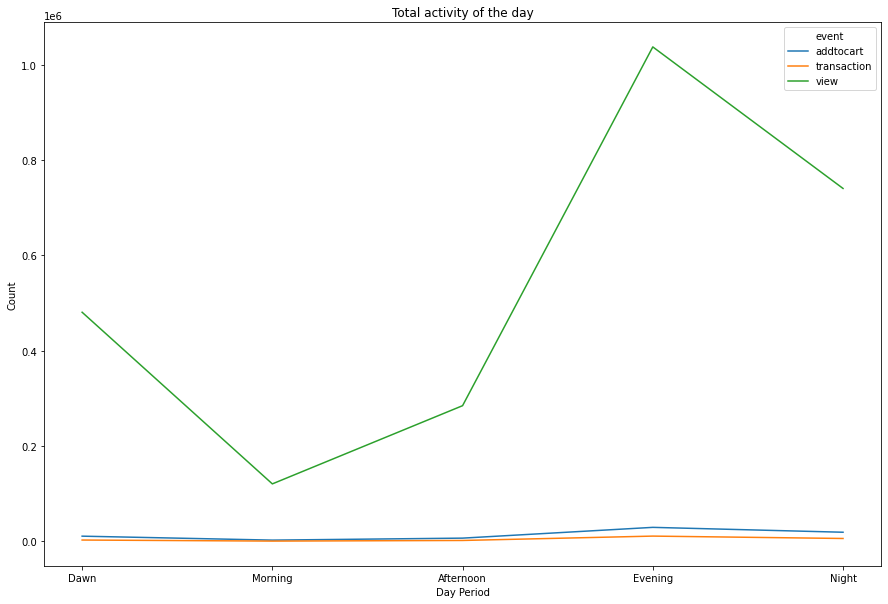

In [43]:
fig, count = plt.subplots(figsize = (15,10))

sorted_periods = {'Dawn': 0, 'Morning': 1, 'Afternoon': 2, 'Evening': 3, 'Night': 4, 'Late Night': 5}
data['Day Period Value'] = data['Day Period'].map(sorted_periods)
data = data.sort_values('Day Period Value').drop('Day Period Value',axis=1)
data = data.reset_index(drop =True)
line = sns.lineplot(x=data['Day Period'], y=data['event_datetime'],sort = False,hue = data['event'])
line.set_title('Total activity of the day')
line.set_ylabel('Count')
line.set_xlabel('Day Period')

#### All transactions inc in period from afternoon till evening

In [44]:
event_df.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date,day_of_week,Year,Month,Day,Hour,minute,Day Period
0,1433221332117,257597,view,355908,NaN,2015-06-02 05:02:12.117,2015-06-02,Tuesday,2015,6,2,5,2,Dawn
1,1433224214164,992329,view,248676,NaN,2015-06-02 05:50:14.164,2015-06-02,Tuesday,2015,6,2,5,50,Dawn
2,1433221999827,111016,view,318965,NaN,2015-06-02 05:13:19.827,2015-06-02,Tuesday,2015,6,2,5,13,Dawn
3,1433221955914,483717,view,253185,NaN,2015-06-02 05:12:35.914,2015-06-02,Tuesday,2015,6,2,5,12,Dawn
4,1433221337106,951259,view,367447,NaN,2015-06-02 05:02:17.106,2015-06-02,Tuesday,2015,6,2,5,2,Dawn


In [45]:
brand = event_df['itemid'].value_counts()
brand

187946    3412
461686    2975
5411      2334
370653    1854
219512    1800
          ... 
145333       1
113185       1
109819       1
302190       1
177353       1
Name: itemid, Length: 235061, dtype: int64

In [46]:
brand_list = [461686]
# filter out a list of rows with brands in top 6.1%
brand_list

[461686]

In [47]:
import plotly.express as px
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go


from plotly.offline import iplot, init_notebook_mode
import cufflinks as cf
import plotly.graph_objs as go

init_notebook_mode(connected=True)
cf.go_offline(connected=True)

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



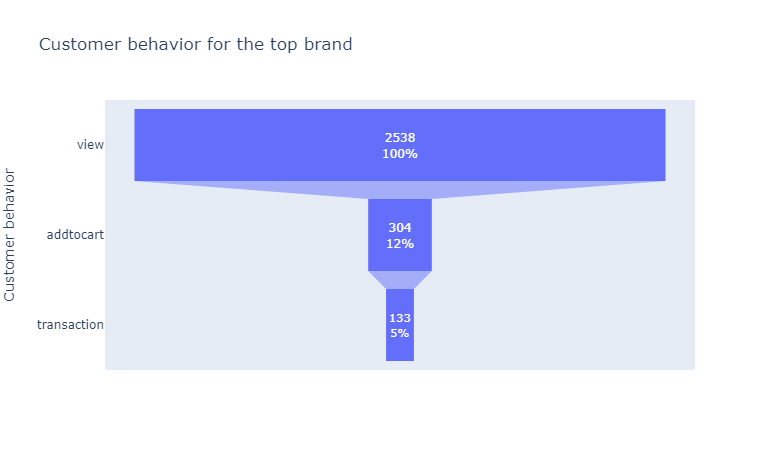

In [48]:
best_brands = event_df[event_df['itemid'].isin(brand_list)]
fig = go.Figure()
for i in range(len(brand_list)):
    name = str(brand_list[i])
    j = best_brands[best_brands['itemid']==int(name)]['event'].value_counts()

    fig.add_trace(go.Funnel(
        name = name,
        y = j.index,
        x = j,
        orientation = "h",
        textposition = "inside",
        textinfo = "value+percent initial"))

fig.update_layout(
    title_text='Customer behavior for the top brand', # title of plot
    yaxis_title_text='Customer behavior', # xaxis label
    xaxis_title_text='Brand performance', # yaxis label
    )

fig.show()

We want to count corresponding to each hour and each event

In [49]:
grp_by_hr_event_type = event_df.groupby(['Hour','event']).count()
grp_by_hr_event_type

timestamp  visitorid  itemid  transactionid  event_datetime  \
Hour event                                                                      
0    addtocart         3705       3705    3705              0            3705   
     transaction       1119       1119    1119           1119            1119   
     view            139454     139454  139454              0          139454   
1    addtocart         3556       3556    3556              0            3556   
     transaction       1037       1037    1037           1037            1037   
...                     ...        ...     ...            ...             ...   
22   transaction       1600       1600    1600           1600            1600   
     view            169627     169627  169627              0          169627   
23   addtocart         3892       3892    3892              0            3892   
     transaction       1311       1311    1311           1311            1311   
     view            153849     153849  153849              0          153849   

                    date  day_of_week    Year   Month     Day  minute  \
Hour event                                                              
0    addtocart      3705         3705    3705    3705    3705    3705   
     transaction    1119         1119    1119    1119    1119    1119   
     view         139454       139454  139454  139454  139454  139454   
1    addtocart      3556         3556    3556    3556    3556    3556   
     transaction    1037         1037    1037    1037    1037    1037   
...                  ...          ...     ...     ...     ...     ...   
22   transaction    1600         1600    1600    1600    1600    1600   
     view         169627       169627  169627  169627  169627  169627   
23   addtocart      3892         3892    3892    3892    3892    3892   
     transaction    1311         1311    1311    1311    1311    1311   
     view         153849       153849  153849  153849  153849  153849   

                  Day Period  
Hour event                    
0    addtocart          3705  
     transaction        1119  
     view             139454  
1    addtocart          3556  
     transaction        1037  
...                      ...  
22   transaction        1600  
     view             169627  
23   addtocart          3892  
     transaction        1311  
     view             153849  

[72 rows x 12 columns]

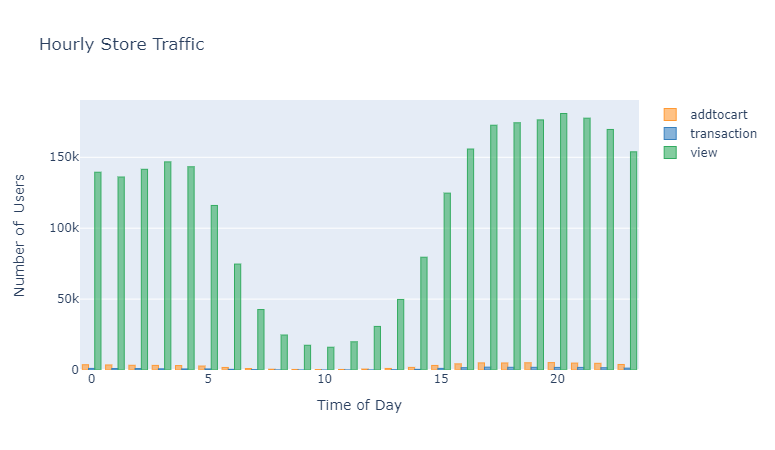

In [50]:
#Check the peak hrs
layout= dict(title="Hourly Store Traffic", xaxis_title="Time of Day", yaxis_title="Number of  Users")
grp_by_hr_event_type['visitorid'].unstack(1).iplot(kind="bar", layout=layout) 

In [51]:
custmoer_behavior_share =event_df.event.value_counts()/len(event_df)*100
custmoer_behavior_share

view           96.682333
addtocart       2.502721
transaction     0.814947
Name: event, dtype: float64

In [52]:
labels = custmoer_behavior_share.index.tolist()
values = custmoer_behavior_share.values.tolist()

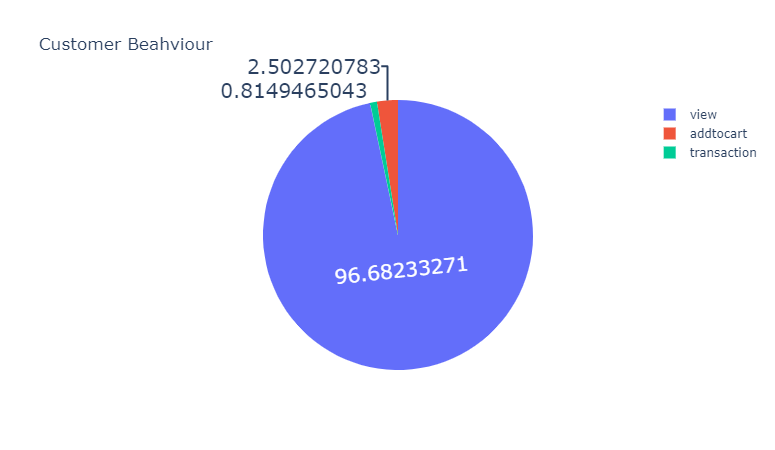

In [53]:
fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20)
fig.update_layout(title="Customer Beahviour")

fig.show()

# Recommender

We need to make some kind of recommendations to the user, like People also view as an example. This requires us to have two latent vectors from event data (items, users) and apply Facorization Machine algorithm on them to get the recommendations.

One kind of recommendations that we can make is to show the users some items that people also make view action with the items that they are viewing now.
This can guide our customers to get better items and make the shopping process easier.

##### So we need to create 2 lists one of people who make transaction and second for items that customers purchases  

In [54]:
event_df.event.value_counts()

view           2664218
addtocart        68966
transaction      22457
Name: event, dtype: int64

We will see some insights on sample data

In [55]:
sample_df = event_df.sample(100000)

In [56]:
# create a list of users who made a single view
customers_view = sample_df[sample_df['event']=="view"].visitorid.unique()
customers_view

array([ 449282,  855511,  345717, ..., 1074728,  684961,  274711])

In [57]:
len(customers_view)

85821

In [58]:
# create a list of items that people view
viewed_items = []

for customer in customers_view:
    viewed_items.append(list(sample_df.loc[(sample_df.visitorid == customer) 
                              & (sample_df['event']=="view")].itemid.values))

In [59]:
viewed_items

[[252183],
 [247782],
 [43429],
 [294255],
 [140065],
 [103221],
 [89202,
  43590,
  125968,
  432925,
  32643,
  90823,
  117677,
  324946,
  108932,
  103221,
  352509,
  362697,
  456276,
  206968,
  261979,
  119736,
  409655,
  651,
  32267,
  237544,
  138427,
  350638,
  453390,
  48378,
  22436,
  229037,
  264178,
  176379,
  43081,
  365437,
  119736,
  394520,
  168671,
  338395,
  15776,
  180009,
  50329,
  281211,
  29940,
  186256,
  116199,
  382958,
  312717,
  398489,
  108308,
  284156,
  44582,
  369933,
  271930,
  154912,
  177458,
  416992,
  288525,
  362414,
  369158,
  301145,
  18986,
  240900,
  54869,
  42002,
  237039,
  225727,
  3146,
  235224,
  52928,
  443829,
  356635,
  303178,
  1644,
  435265,
  96940,
  62394,
  379306,
  283766,
  226820,
  190463,
  250962,
  32643,
  372169,
  189889],
 [452711],
 [349188],
 [296256, 55456],
 [267815],
 [292952],
 [211971],
 [107394],
 [223538,
  174576,
  188663,
  170262,
  190732,
  233734,
  216930,
  1421

In [60]:
len(viewed_items)

85821

In [61]:
sample_df.head()

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date,day_of_week,Year,Month,Day,Hour,minute,Day Period
876235,1439732190924,449282,view,252183,NaN,2015-08-16 13:36:30.924,2015-08-16,Sunday,2015,8,16,13,36,Afternoon
996891,1440271214809,855511,view,247782,NaN,2015-08-22 19:20:14.809,2015-08-23,Saturday,2015,8,22,19,20,Evening
891329,1439770063696,345717,view,43429,NaN,2015-08-17 00:07:43.696,2015-08-18,Monday,2015,8,17,0,7,Night
377556,1434714971056,1235357,view,294255,NaN,2015-06-19 11:56:11.056,2015-06-19,Friday,2015,6,19,11,56,Morning
478408,1435163937548,420833,view,140065,NaN,2015-06-24 16:38:57.548,2015-06-24,Wednesday,2015,6,24,16,38,Evening


In [62]:
# the two lists
print('Customers views sample', customers_view[:5])
print('Items viewed sample', viewed_items[:5])

Customers views sample [ 449282  855511  345717 1235357  420833]
Items viewed sample [[252183], [247782], [43429], [294255], [140065]]


In [63]:
sample_df[sample_df["visitorid"] == 824082]

,timestamp,visitorid,event,itemid,transactionid,event_datetime,date,day_of_week,Year,Month,Day,Hour,minute,Day Period
1362422,1441993329829,824082,view,405380,NaN,2015-09-11 17:42:09.829,2015-09-11,Friday,2015,9,11,17,42,Evening
1379288,1442099983004,824082,view,187649,NaN,2015-09-12 23:19:43.004,2015-09-12,Saturday,2015,9,12,23,19,Night
1374918,1442090699683,824082,transaction,193544,14583.0,2015-09-12 20:44:59.683,2015-09-13,Saturday,2015,9,12,20,44,Evening
1339717,1441904535186,824082,view,157784,NaN,2015-09-10 17:02:15.186,2015-09-10,Thursday,2015,9,10,17,2,Evening
1340430,1441922960262,824082,view,109308,NaN,2015-09-10 22:09:20.262,2015-09-10,Thursday,2015,9,10,22,9,Night
1337824,1441921400940,824082,view,405380,NaN,2015-09-10 21:43:20.940,2015-09-10,Thursday,2015,9,10,21,43,Evening


We will createfunction that takes an item id -the currently viewed item- and shows some related items to it.


In [64]:
def recommend_items(item_id, viewed_items):
    recommended_items = []

    for items in viewed_items:

        if item_id in items:
            recommended_items += items
            
    # reomve duplicated items and merge the lists in one lsit
    recommended_items = list(set(recommended_items) - set([item_id]))
    return recommended_items

In [65]:
#To test the function, we may pass an item id and look for the results
recommend_items(405380, viewed_items)

[434688,
 187649,
 286722,
 412419,
 227332,
 334601,
 466443,
 389135,
 289298,
 463635,
 243222,
 261914,
 108828,
 444190,
 159780,
 179238,
 128296,
 463402,
 89901,
 189231,
 190000,
 368689,
 130101,
 164923,
 119868,
 343104,
 355393,
 832,
 298056,
 455240,
 324429,
 186702,
 206673,
 241752,
 157784,
 167256,
 88669,
 335457,
 96609,
 147555,
 91235,
 124264,
 19567,
 386160,
 234613,
 58741,
 96377,
 428921,
 466301,
 122496,
 239746,
 330370,
 367490,
 459139,
 78729,
 192138,
 151945,
 449169,
 135066,
 449435,
 239774,
 5281,
 92580,
 188069,
 37029,
 69799,
 445351,
 150700,
 294322,
 68787,
 192950,
 134839,
 119736,
 224700,
 321984,
 218817,
 157121,
 332227,
 363206,
 307410,
 90579,
 239571,
 96985,
 17114,
 149724,
 33245,
 168671,
 174560,
 148707,
 198381,
 268020,
 109308,
 230397]

### Data Preparation

We will work only on view event

In [66]:
event_df=event_df[event_df["event"] == "view"]

In [67]:
event_df.event.value_counts()

view    2664218
Name: event, dtype: int64

In [68]:
from scipy.sparse import coo_matrix
from sklearn import preprocessing

In [69]:
# create the final matrix
event_df = event_df.sort_values('date').reset_index(drop=True)
event_df = event_df[['visitorid','itemid','event', 'date']]
event_df.head(5)

,visitorid,itemid,event,date
0,1148414,320130,view,2015-05-03
1,1219824,185196,view,2015-05-03
2,299560,413166,view,2015-05-03
3,737724,315543,view,2015-05-03
4,1363694,327150,view,2015-05-03


In [70]:
# split the data into train and test data
split_point = np.int(np.round(event_df.shape[0]*0.8))
events_train = event_df.iloc[0:split_point]
events_test = event_df.iloc[split_point::]
# check that visitorid and itemid already exist on the train data
events_test = events_test[(events_test['visitorid'].isin(events_train['visitorid'])) 
                          & (events_test['itemid'].isin(events_train['itemid']))]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



We have a categorical feature in the data -event- so we will apply label encoder on it

Label Encoding

In [71]:
id_cols=['visitorid','itemid']
trans_cat_train = dict()
trans_cat_test = dict()

for k in id_cols:
    cat_enc = preprocessing.LabelEncoder()
    trans_cat_train[k] = cat_enc.fit_transform(events_train[k].values)
    trans_cat_test[k] = cat_enc.transform(events_test[k].values)

In [72]:
trans_cat_train 

{'visitorid': array([ 915627,  972604,  238877, ...,  167709,   98324, 1004763]),
 'itemid': array([145986,  84553, 188496, ..., 140602,  21849,   1364])}

In [73]:
ratings = dict()

cat_enc = preprocessing.LabelEncoder()
ratings['train'] = cat_enc.fit_transform(events_train.event)
ratings['test'] = cat_enc.transform(events_test.event)

In [74]:
ratings

{'train': array([0, 0, 0, ..., 0, 0, 0]),
 'test': array([0, 0, 0, ..., 0, 0, 0])}

In [75]:
n_users=len(np.unique(trans_cat_train['visitorid']))
n_items=len(np.unique(trans_cat_train['itemid']))

Now lets merge the two dictionaries into one matrix

In [76]:
rate_matrix = dict()

In [77]:
rate_matrix['train'] = coo_matrix((ratings['train'], 
                                   (trans_cat_train['visitorid'], 
                                    trans_cat_train['itemid'])), 
                                    shape=(n_users,n_items))

In [78]:
rate_matrix['test'] = coo_matrix((ratings['test'], 
                                   (trans_cat_test['visitorid'], 
                                    trans_cat_test['itemid'])), 
                                    shape=(n_users,n_items))

In [79]:
rate_matrix['train']

<1122184x212740 sparse matrix of type '<class 'numpy.int64'>'
	with 2131374 stored elements in COOrdinate format>

# LightFM Model

In [80]:
import gc
gc.collect()

1259

In [81]:
gc.collect()

23

In [94]:
from lightfm import LightFM
import lightfm
from lightfm.evaluation import auc_score

In [83]:
# model creation and training
model = LightFM(no_components=50, loss='warp')
model.fit(rate_matrix['train'], epochs=10, num_threads = 4)

In [84]:
auc_score(model, rate_matrix['train'], num_threads = 4).mean()

0.5003019

In [85]:
auc_score(model, rate_matrix['test'], num_threads=4).mean()

0.50012183

In [96]:
lightfm.evaluation.recall_at_k(model, rate_matrix['test'], train_interactions=None, k=10, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

array([0., 0., 0., ..., 0., 0., 0.])

In [97]:
lightfm.evaluation.reciprocal_rank(model, rate_matrix['test'], train_interactions=None, user_features=None, item_features=None, preserve_rows=False, num_threads=4, check_intersections=True)

array([2.1422909e-05, 5.3919402e-06, 7.7339522e-05, ..., 7.6178867e-06,
       8.7242524e-06, 6.0043112e-06], dtype=float32)